# One versus all as a anomaly detection problem

Inspired from Ruff 2018.

In this study, we train each our model to identify one of the ten digits in the MNIST dataset. All the other digits are considered as "outliers" ; they are not seen during training, and during evaluation the model has to predict if an image is in the normal class or in the outlier class.

This evaluation method will be our standard to test the performances of a model. We will use the classification metrics ROC-AUC to measure the performance of a model and compare them with pre-existing methods.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.random import normal
import tensorflow.keras as keras

from tensorflow.keras import Model, layers
from tensorflow.keras.datasets import mnist

print(tf.__version__)

# DRIVE
from google.colab import drive
drive.mount('/content/gdrive')
import sys
sys.path.append('/content/gdrive/My Drive/BACMMAN_DISTNET/')

from uad.callbacks.metrics import AUCCallback, PrecisionRecallCallback
from uad.MNIST.draw_line import set_anomaly, predict_anomalies, contour_anomalies, plot_anomalies
from uad.MNIST.one_vs_all import plot_prediction, plot_per_digit_proportion
from uad.decision.reconstruction import is_anormal, decision_function, binarize_set
from uad.models.variational_autoencoder import ConvolutionalVAE
from uad.diagnostic.visualisation import plot_tSNE
from uad.diagnostic.metrics import compute_ROC, compute_AUC, plot_ROC

!nvidia-smi

2.3.0
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Tue Aug 11 08:50:38 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Import data

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = np.expand_dims(x_train, -1).astype("float32") / 255
x_test = np.expand_dims(x_test, -1).astype("float32") / 255

interest_digit = 0

# x_val, y_val_bin = x_train[-1000:], binarize_set(y_train[-1000:], interest=interest_digit)

# train set sorted by digits: digits_train[i] = x_train elements where y_train == i
digits_train = np.array([x_train[np.where(y_train[:-1000] == i)] for i in range(10)])

x_val = np.concatenate((digits_train[0][:500], digits_train[1][:50], 
                        digits_train[2][:50], digits_train[3][:50],
                        digits_train[4][:50], digits_train[5][:50],
                        digits_train[6][:50], digits_train[7][:50],
                        digits_train[8][:50], digits_train[9][:100]), axis=0)
y_val_bin = np.concatenate((np.zeros(500), np.ones(500)), axis=0)

# training set contains only zeros (for training on zeros)
labels_bin = binarize_set(y_train, interest=interest_digit)
x_train_bin, y_train_bin = digits_train[interest_digit][:-500], y_train[np.where(y_train[:-500] == interest_digit)][:-500]
y_test_bin = binarize_set(y_test, interest=interest_digit)

print(x_train_bin.shape, y_train_bin.shape, x_val.shape, y_val_bin.shape)

11493376/11490434 [==============================] - 0s 0us/step
(5325, 28, 28, 1) (5377,) (1000, 28, 28, 1) (1000,)


## Build model

For this introduction, the model will learn to reconstruct the digit 0.

In [3]:
from uad.models.architecture import get_unet_vae

auc_callback = AUCCallback(x_val, y_val_bin)
val_acc_callback = PrecisionRecallCallback(x_val, y_val_bin, prefix="val")
train_acc_callback = PrecisionRecallCallback(x_train[:2000], labels_bin[:2000], prefix="train")

# n_filters = 16
# n_contractions = 3
# input_dims = (28, 28, 1)
# latent_depth = n_filters * int(2**n_contractions)
# latent_dims = (int(256 / (2**n_contractions)), int(32 / (2**n_contractions)), latent_depth)
# batchnorm, dropout, spatial_dropout = False, 0.2, 0
# activation_function = "sigmoid"
# k_size = (3, 3)
# self_attention = False
# final_activation, layer_norm = "sigmoid", False
# padding = [[0, 0], [2, 2], [2, 2], [0, 0]]

from uad.models.variational_autoencoder import VAE, Sampling

def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True, activation1="sigmoid",
                 activation2="sigmoid"):
    """Function to add 2 convolutional layers with the parameters passed to it
    activation1: name of the activation function to apply. If none, pass "" (empty string)
    activation2: name of the activation function to apply. If none, pass "" (empty string)
    """
    # first layer
    x = layers.Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), \
                      kernel_initializer='he_normal', padding='same')(input_tensor)
    if batchnorm:
        x = layers.BatchNormalization()(x)
    if activation1 != "":
        x = layers.Activation(activation1)(x)

    # second layer
    x = layers.Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), \
                      kernel_initializer='he_normal', padding='same')(input_tensor)
    if batchnorm:
        x = layers.BatchNormalization()(x)
    if activation2 != "":
        x = layers.Activation(activation2)(x)

    return x

def build_VAE(n_filters=16, n_contractions=3):
    latent_dim = 8
    latent_side = int(2 ** (5 - n_contractions))  
    batchnorm = False
    dropout = 0.2
    k_size = 3

    act1, act2, final_activation = "sigmoid", "sigmoid", "sigmoid"

    encoder_inputs = layers.Input(shape=(28, 28, 1), name="encoder_inputs")

    paddings = tf.constant([[0, 0], [2, 2], [2, 2], [0, 0]])  # shape d x 2 where d is the rank of the tensor and 2 represents "before" and "after"
    x = tf.pad(encoder_inputs, paddings, name="pad")

    for k in range(n_contractions):
        x = conv2d_block(x, n_filters * (2**k), kernel_size=k_size, batchnorm=batchnorm, 
                     activation1=act1, activation2=act2)
        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Dropout(dropout)(x)

    z_mean = layers.Conv2D(latent_dim, 1, strides=1, name="z_mean")(x)
    z_log_var = layers.Conv2D(latent_dim, 1, strides=1, name="z_log_var")(x)
    z = Sampling()((z_mean, z_log_var))

    encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

    # Define decoder model.
    latent_inputs = layers.Input(shape=(latent_side, latent_side, latent_dim), 
                                 name="z_sampling")
    x = latent_inputs
    
    for k in range(n_contractions, 0, -1):
        x = layers.Conv2DTranspose(n_filters * (2**(k - 1)), (k_size, k_size), strides=(2, 2), 
                               padding='same', name=f"u{n_contractions + k}")(x)
        x = layers.Dropout(dropout)(x)
        if k == 1:
            decoder_outputs = conv2d_block(x, 1, kernel_size=k_size, batchnorm=batchnorm, 
                              activation1=act1, activation2=act2)
        else:
            x = conv2d_block(x, n_filters * (2**(k - 1)), kernel_size=k_size, batchnorm=batchnorm, 
                              activation1=act1, activation2=act2)

    crop = tf.image.resize_with_crop_or_pad(decoder_outputs, 28, 28)

    decoder = Model(inputs=latent_inputs, outputs=crop, name="decoder")

    return VAE(encoder, decoder, reconstruction_loss="xent")

vae = build_VAE(n_filters=16, n_contractions=3)

In [5]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, TensorBoard
from uad.models.variational_autoencoder import VAE

# vae = VAE(encoder, decoder, dims=input_dims, reconstruction_loss="xent", BETA=1)
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))

reduce_lr = ReduceLROnPlateau(
    monitor='val_reconstruction_loss', factor=0.1, patience=5, verbose=1, mode='auto',
    min_delta=0.0001, cooldown=0, min_lr=0,)

import datetime, os
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(logdir, histogram_freq=1)

history = vae.fit(x_train_bin, x_train_bin, validation_data=(x_val, y_val_bin), epochs=100, batch_size=128, callbacks=[tensorboard_callback, reduce_lr])

Epoch 1/100
 1/42 [..............................] - ETA: 0s - loss: 483.7644 - reconstruction_loss: 483.1907 - kl_loss: 0.5736WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
42/42 [==============================] - 1s 22ms/step - loss: 364.3059 - reconstruction_loss: 363.8827 - kl_loss: 0.4232 - val_loss: 276.0974 - val_reconstruction_loss: 275.2018 - val_kl_loss: 0.8957
Epoch 2/100
42/42 [==============================] - 0s 9ms/step - loss: 264.2335 - reconstruction_loss: 262.6248 - kl_loss: 1.6087 - val_loss: 218.8679 - val_reconstruction_loss: 217.2139 - val_kl_loss: 1.6540
Epoch 3/100
42/42 [==============================] - 0s 10ms/step - loss: 214.2742 - reconstruction_loss: 212.4286 - kl_loss: 1.8457 - val_loss: 210.7789 - val_reconstruction_loss: 208

In [ ]:
print(vae.encoder.summary(), vae.decoder.summary())

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs

In [4]:
import os
os.chdir("/content/gdrive/My Drive/BACMMAN_DISTNET/models/")
vae.load_weights("vae_MNIST_4x4x128_mse_weights")

NotFoundError: ignored

In [ ]:
import os
os.chdir("/content/gdrive/My Drive/BACMMAN_DISTNET/models/VAE_ls=4x4x16")
vae.build(input_dims)
tf.keras.models.save_model(vae, "standard_VAE_4x4x8")

Precision is always: 90%, from the beginning. This is because we have a huge class imbalance: a network that predicts 1 (anomaly) randomly will have 90% accuracy! This is why precision is not so pertinent in our case. Same for recall: it is 100% which means that there is no false negative. Indeed in the beginning of training, reconstruction loss (on which is based anomaly prediction) is so huge that each image is considered as abnormal. As a consequence, no false positives at all.

# Predictions analysis

We take the following convention: the positive class is constituted of the anomalous items. A wrongly predicted anormal digit is considered as a false positive. 

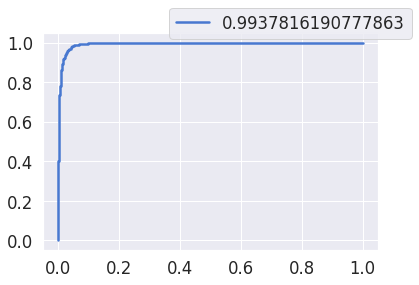

In [6]:
# compute ROC

from sklearn.metrics import auc, roc_curve

def score_samples(model, data, interest_digit=0):
    predictions = model.predict(data)
    y_scores = tf.reduce_sum((predictions - data) ** 2, axis=(1, 2, 3))
    return y_scores.numpy()

y_scores = score_samples(vae, x_test, interest_digit=0)
fpr, tpr, _ = roc_curve(y_test_bin, y_scores, pos_label=1)

fig, ax = plt.subplots(1, 1)
ax.plot(fpr, tpr, label=auc(fpr, tpr))
fig.legend()

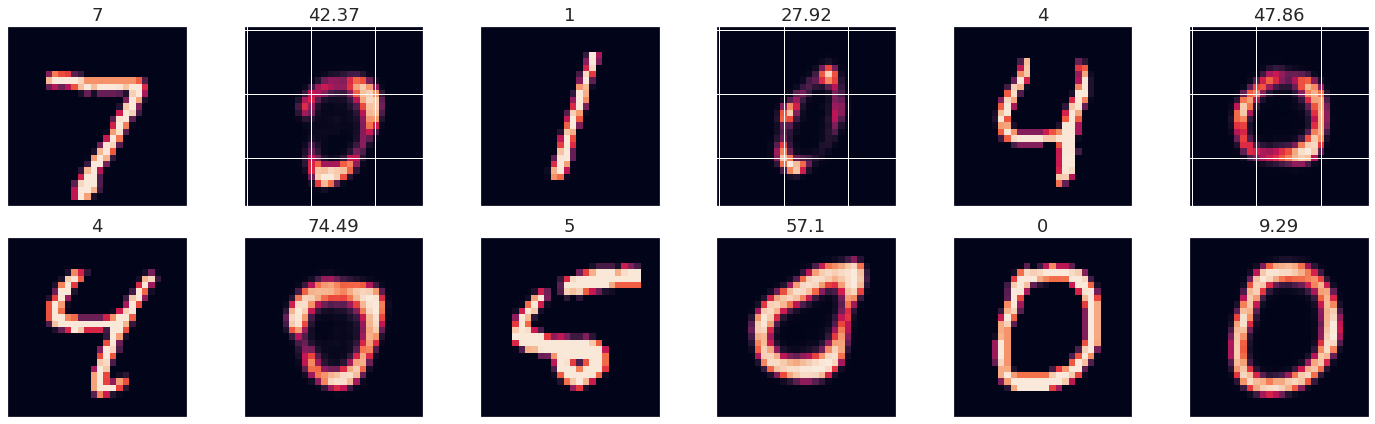

In [19]:
predictions = vae.predict(x_test)
y_scores = score_samples(vae, x_test, interest_digit=interest_digit)

n_plots = 6

fig, axes = plt.subplots(2, n_plots, figsize=(20, 6), sharex="all", sharey="all")

for i in range(0, n_plots - 1, 2):
    axes[0][i].imshow(x_test[i].squeeze(-1))
    axes[0][i].set_title(y_test[i])
    axes[0][i+1].imshow(predictions[i].squeeze(-1))
    axes[0][i+1].set_title(round(y_scores[i], 2))

    axes[1][i].imshow(x_test[i+n_plots].squeeze(-1))
    axes[1][i].set_title(y_test[i+n_plots])
    axes[1][i+1].imshow(predictions[i+n_plots].squeeze(-1))
    axes[1][i+1].set_title(round(y_scores[i+n_plots], 2))

    axes[0][i].get_xaxis().set_visible(False)
    axes[0][i].get_yaxis().set_visible(False)
    axes[1][i].get_xaxis().set_visible(False)
    axes[1][i].get_yaxis().set_visible(False)
    axes[1][i+1].get_xaxis().set_visible(False)
    axes[1][i+1].get_yaxis().set_visible(False)

fig.tight_layout()
plt.savefig("/content/gdrive/My Drive/BACMMAN_DISTNET/imgs/reconstructions_MNIST")

## Compute AUROC score per normal class

Here we will successively consider each digit as the normal class, train a model on it and compute the AUC, thus giving a full evaluation of its potential.

In [ ]:
from uad.diagnostic.metrics import compute_AUC_on_all

n_filters, n_contractions = 16, 3
n_classes, replicas = 10, 10
epochs = 30
auc_scores = np.zeros((10, replicas))  # (digits, replicas)

for k in range(n_classes):  # each digit
    for i in range(replicas): # 10 replicas
        model = build_VAE(n_filters, n_contractions)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))
        model.fit(digits_train[k], digits_train[k], epochs=epochs, batch_size=128, verbose=0)
        predictions = model.predict(x_test)
        y_test_bin = binarize_set(y_test, interest=k)
        fpr, tpr, _ = compute_ROC(x_test, predictions, y_test, criterion="l2", interest_class=k)
        auc = compute_AUC(fpr, tpr)
        print(f"Digit {k}, Iteration {i}, Final AUC: {auc}")
        auc_scores[k, i] = auc

print(auc_scores)
np.save("/content/gdrive/My Drive/BACMMAN_DISTNET/models/auc_per_class_MNIST_10replicas", auc_scores)

Digit 0, Iteration 0, Final AUC: 0.9921011131725418
Digit 0, Iteration 1, Final AUC: 0.9956685822887914
Digit 0, Iteration 2, Final AUC: 0.9912104620118558
Digit 0, Iteration 3, Final AUC: 0.9884309244762206
Digit 0, Iteration 4, Final AUC: 0.9903752432236752
Digit 0, Iteration 5, Final AUC: 0.9945279198153762
Digit 0, Iteration 6, Final AUC: 0.9920158151952577
Digit 0, Iteration 7, Final AUC: 0.993653785239151
Digit 0, Iteration 8, Final AUC: 0.9926625639169193
Digit 0, Iteration 9, Final AUC: 0.9937421376532874
Digit 1, Iteration 0, Final AUC: 0.9988994983489494
Digit 1, Iteration 1, Final AUC: 0.9984928106621347
Digit 1, Iteration 2, Final AUC: 0.9985025504943214
Digit 1, Iteration 3, Final AUC: 0.9984133018279577
Digit 1, Iteration 4, Final AUC: 0.9985826556447546
Digit 1, Iteration 5, Final AUC: 0.9985642692268512
Digit 1, Iteration 6, Final AUC: 0.9991267942286526
Digit 1, Iteration 7, Final AUC: 0.9991206322940038
Digit 1, Iteration 8, Final AUC: 0.9987827197487521
Digit 1, Iter

In [ ]:
# mean +- std over 10 iterations for each class

stats = np.array([[np.mean(row), np.std(row)] for row in auc_scores])
print(stats * 100)

[[9.92438855e+01 2.00359575e-01]
 [9.98666786e+01 2.93031118e-02]
 [8.36664876e+01 7.83474215e-01]
 [9.12357311e+01 1.40003327e+00]
 [9.10871756e+01 1.46128200e+00]
 [9.12168108e+01 2.05037373e+00]
 [9.44584291e+01 1.23796652e+00]
 [9.47490561e+01 8.91003162e-01]
 [8.75373277e+01 1.93190562e+00]
 [9.42726963e+01 1.11377537e+00]]


We worked with a fully convolutional, 3-contraction blocks, (4, 4, 16) dimensional latent space. Compared to the AUC scores given in Ruff 2018: we achieve similar or strictly better performances than:
1. OC-SVM/SVDD: except for classes 4 and 8
2. KDE: everwhere
3. IF: except for digits 2, 4 and 8
4. DCAE: everywhere
5. AnoGAN: everywhere
6. Soft-bound deep SVDD: except for 2, 4, 6, 8 and 9
7. One-class deep SVDD: except for 2, 4, 6, 8, and 9.

980 normal examples
9020 normal examples


(<Figure size 1080x576 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f618649bb00>,
       dtype=object))

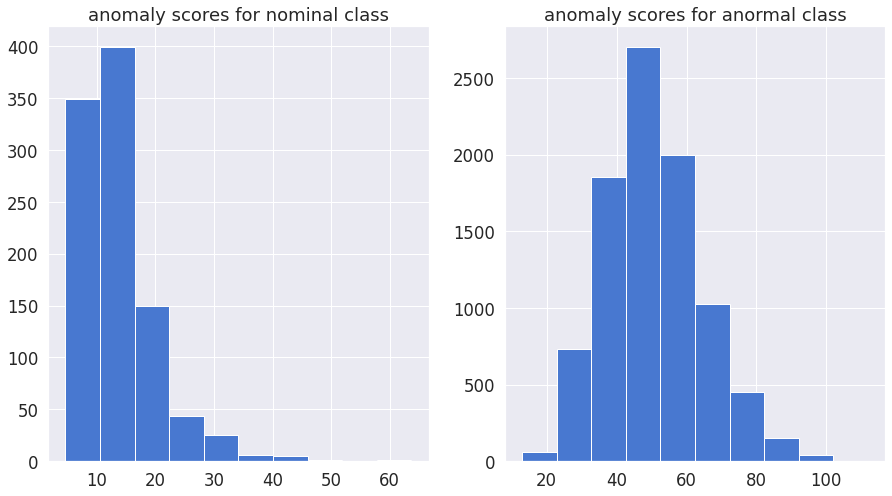

In [7]:
# plot histograms

def plot_scores_distrib(self, data, y_trues, interest_digit=0):
    y_scores = score_samples(self, data, interest_digit=interest_digit)

    scores_nominal = y_scores[y_trues == 0.]
    scores_anormal = y_scores[y_trues == 1.]

    print(f"{scores_nominal.shape[0]} normal examples")
    print(f"{scores_anormal.shape[0]} normal examples")

    fig, axes = plt.subplots(1, 2, figsize=(15, 8))
    axes[0].hist(scores_nominal)
    axes[0].set_title("anomaly scores for nominal class")
    axes[1].hist(scores_anormal)
    axes[1].set_title("anomaly scores for anormal class")

    return fig, axes

plot_scores_distrib(vae, x_test, y_test_bin, interest_digit=0)

### Plot single item

In [ ]:
vae_predictions = vae.predict(x_test)

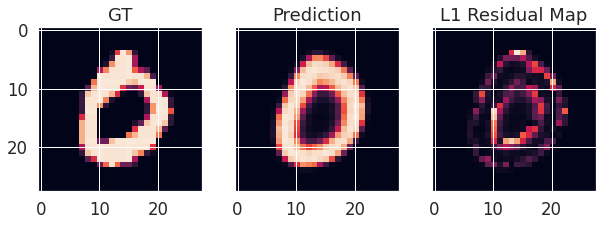

In [ ]:
if vae_predictions.shape == (vae_predictions.shape[0], 28, 28, 1):
    vae_predictions = np.squeeze(vae_predictions, axis=-1)
    
if x_test.shape == (x_test.shape[0], 28, 28, 1):
    x_test_im = np.squeeze(x_test, axis=-1)
else:
    x_test_im = x_test

idx = 3

fig, ax = plot_prediction(x_test_im[idx], vae_predictions[idx])

## Plot t-SNE visualisation of latent space



t-SNE inputs shape: (10000, 784)
t-SNE inputs shape: (10000, 28)
t-SNE inputs shape: (10000, 28)
t-SNE inputs shape: (10000, 1)


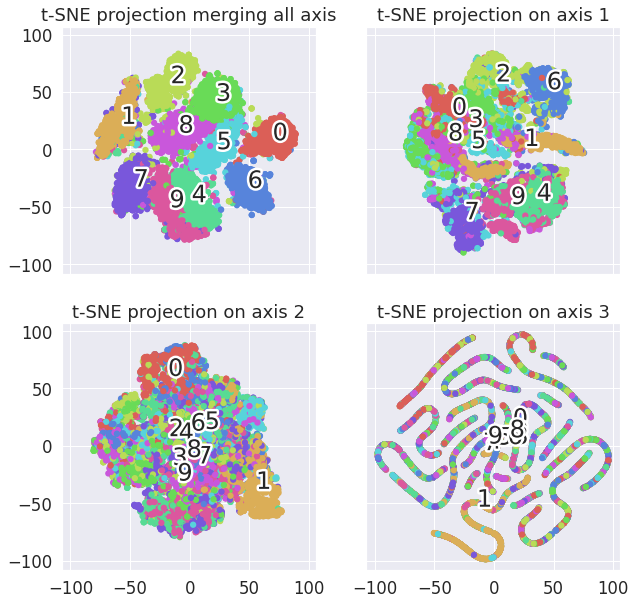

In [ ]:
fig, axis = plt.subplots(2, 2, figsize=(10, 10), sharex="all", sharey="all")

for i, ax in enumerate(axis.flatten()):
  plot_tSNE(x_test, y_test, axis=i, plt_ax=ax)
  if i == 0:
    ax.set_title(f"t-SNE projection merging all axis")
  else:
    ax.set_title(f"t-SNE projection on axis {i}")

## Plot 2D-PCA

In order to visualise the latent space embedding, we can use another dimensionality reduction method: PCA

In [ ]:
def compute_PCA(dataset, n_dims=2, desired_axis=-1):
    """
    Performs PCA on the given dataset, along the desired axis and outputs the result
    vectors with the given dimen. If a third-rank is given, takes the mean of the other axis, to get a final vector
    along the desired axis (since t-SNE only takes vectors as inputs and we don't
    want to mix the different axis)
    :param dataset: np.array
    :param desired_axis: axis on which to project the dataset (e.g. to project
    on channels : axis=-1 in channels_last configuration). None or 0 if you want to
    merge all axis in one.
    :return: an array containing the same number of items than in the given
    dataset but with the output dimension of the t-SNE transformation
    """
    if len(dataset.shape) > 2:  # third-rank tensor or matrix
        if desired_axis is None or desired_axis == 0:
            if len(dataset.shape) == 4:
                batch, x, y, z = dataset.shape
                dataset = np.reshape(dataset, (batch, x * y * z))
            elif len(dataset.shape) == 3:
                batch, x, y = dataset.shape
                dataset = np.reshape(dataset, (batch, x * y))
            else:
                raise NotImplementedError("Input dataset should be a batch of 3 or 2-rank tensors at most")
        else:  # merge only non desired axis by taking the mean along each
            axes = range(len(dataset.shape))
            axes = np.delete(axes, desired_axis)
            axes = np.delete(axes, 0)  # keep first axis (individual elements)
            while axes != []:
                dataset = np.mean(dataset, axis=axes[0])  # perform mean along the non-desired axis
                axes = [a - 1 for a in axes]
                del axes[0]
    print(f"PCA inputs shape: {dataset.shape}")
    return PCA(n_components=n_dims).fit_transform(dataset)


def plot_PCA(dataset, colors, axis=-1, n_dims=2, plot_center={"bary": False, "center": False}, plt_ax=None):
    """
    Plot the PCA projection of a given dataset
    :param dataset: input images
    :param colors: original labels which serve as colors
    :param plot_center:
    :param axis: axis along which to perform t-SNE
    :param plt_ax: matplotlib axis object on which to plot the result
    :return: matplotlib figure, axis, scatter and texts
    """
    x = compute_PCA(dataset, n_dims=n_dims, desired_axis=axis)

    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))
    #     palette = np.array(colors)

    if n_dims == 2:
      # create a scatter plot.
      if plt_ax is None:
          f = plt.figure(figsize=(8, 8))
          plt_ax = plt.subplot(aspect='equal')
          sc = plt_ax.scatter(x[:, 0], x[:, 1], lw=0, s=40, c=palette[colors.astype(np.int)])
          plt.xlim(-25, 25)
          plt.ylim(-25, 25)
          plt_ax.axis('on')
          plt_ax.axis('tight')
      else:
          f = None
          sc = plt_ax.scatter(x[:, 0], x[:, 1], lw=0, s=40, c=palette[colors.astype(np.int)])
          plt.xlim(-25, 25)
          plt.ylim(-25, 25)
          plt_ax.axis('on')
          plt_ax.axis('tight')

      # add the labels for each digit corresponding to the label
      txts = []

      for i in range(num_classes):
          # Position of each label at median of data points.

          xtext, ytext = np.median(x[colors == i, :], axis=0)
          txt = plt_ax.text(xtext, ytext, str(i), fontsize=24)
          txt.set_path_effects([
              PathEffects.Stroke(linewidth=5, foreground="w"),
              PathEffects.Normal()])
          txts.append(txt)

      # plot the center
      if np.any(plot_center["bary"]):
          plt_ax.plot(plot_center["bary"][0], plot_center["bary"][1], "x", c="r", markersize=18)
          plt_ax.text(plot_center["bary"][0], plot_center["bary"][1], "bary", fontsize=20)
      if np.any(plot_center["center"]):
          plt_ax.plot(plot_center["center"][0], plot_center["center"][1], "x", c="b", markersize=18)
          plt_ax.text(plot_center["center"][0], plot_center["center"][1], "center", fontsize=20)
    
    elif n_dims == 3:
      if plt_ax is None:
          f = plt.figure(figsize=(8, 8))
          plt_ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
          sc = plt_ax.scatter(x[:, 0], x[:, 1], x[:, 2], s=40, lw=0, c=palette[colors.astype(np.int)])
          plt.xlim(-25, 25)
          plt.ylim(-25, 25)
          plt_ax.axis('on')
          plt_ax.axis('tight')
      else:
          f = None
          sc = plt_ax.scatter(x[:, 0], x[:, 1], x[:, 2], s=40, lw=0, c=palette[colors.astype(np.int)])
          plt.xlim(-25, 25)
          plt.ylim(-25, 25)
          plt_ax.axis('on')
          plt_ax.axis('tight')

      # add the labels for each digit corresponding to the label
      txts = []

      for i in range(num_classes):
          # Position of each label at median of data points.

          xtext, ytext, ztext = np.median(x[colors == i, :], axis=0)
          txt = plt_ax.text(xtext, ytext, ztext, str(i), fontsize=24)
          txt.set_path_effects([
              PathEffects.Stroke(linewidth=5, foreground="w"),
              PathEffects.Normal()])
          txts.append(txt)

    else:
      raise NotImplementedError("Output dimension should be either 2 or 3")

    return f, plt_ax, sc, txts

In [ ]:
z_means, z_log_vars, _ = vae.encoder.predict(x_test)

PCA inputs shape: (10000, 128)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


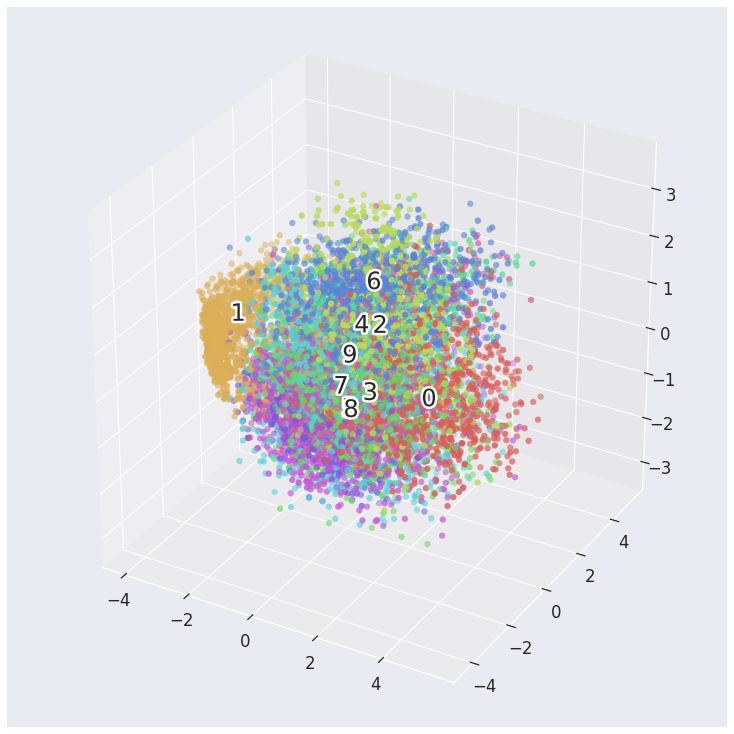

In [ ]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.patheffects as PathEffects
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import time
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(4, figsize=(10, 10))
ax = Axes3D(fig) # For 3D plot
fig.add_subplot(plot_PCA(z_means, y_test, axis=i, n_dims=3, plt_ax=ax)[1])

In [ ]:
predictions,zlv, _ = vae.encoder.predict(x_test[:5000])

(5000, 4, 4, 16)
Done super-pixel (0, 0)
Done super-pixel (0, 1)
Done super-pixel (0, 2)
Done super-pixel (0, 3)
Done super-pixel (1, 0)
Done super-pixel (1, 1)
Done super-pixel (1, 2)
Done super-pixel (1, 3)
Done super-pixel (2, 0)
Done super-pixel (2, 1)
Done super-pixel (2, 2)
Done super-pixel (2, 3)
Done super-pixel (3, 0)
Done super-pixel (3, 1)
Done super-pixel (3, 2)
Done super-pixel (3, 3)
(5000,) (5000,)
(5000,) (5000,)
(5000,) (5000,)
(5000,) (5000,)
(5000,) (5000,)
(5000,) (5000,)
(5000,) (5000,)
(5000,) (5000,)


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


(5000,) (5000,)
(5000,) (5000,)
(5000,) (5000,)
(5000,) (5000,)
(5000,) (5000,)
(5000,) (5000,)
(5000,) (5000,)
(5000,) (5000,)


(<Figure size 1440x1440 with 16 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f673f245358>,
       dtype=object),
 [Text(-1.2030001, 2.563528, '0'),
  Text(2.0247297, 1.4272759, '1'),
  Text(1.9860463, 1.5951408, '2'),
  Text(0.41414553, -3.8220482, '3'),
  Text(2.1557965, -1.4280138, '4'),
  Text(-2.2849355, 3.0999596, '5'),
  Text(-0.49149698, 0.9370675, '6'),
  Text(2.3695273, -0.62571836, '7'),
  Text(-0.23244801, 2.2524278, '8'),
  Text(0.46956497, -0.8662963, '9'),
  Text(nan, nan, '10'),
  Text(1.1654668, 0.5223215, '0'),
  Text(-0.7402143, 0.51662356, '1'),
  Text(3.1808076, 3.0693192, '2'),
  Text(-2.4101543, -2.321498, '3'),
  Text(-2.4437547, 2.3671093, '4'),
  Text(1.9136246, -4.504262, '5'),
  Text(5.4850655, -0.9748814, '6'),
  Text(2.2078886, -2.6791458, '7'),
  Text(-0.6334918, -0.59660655, '8'),
  Text(4.3167324, 2.050018, '9'),
  Text(nan, nan, '10'),
  Text(1.10133, 3.8805594, '0'),
  Text(0.66838753, 2.8697722, '1'),
  Text(0.34399033, -2.43835

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

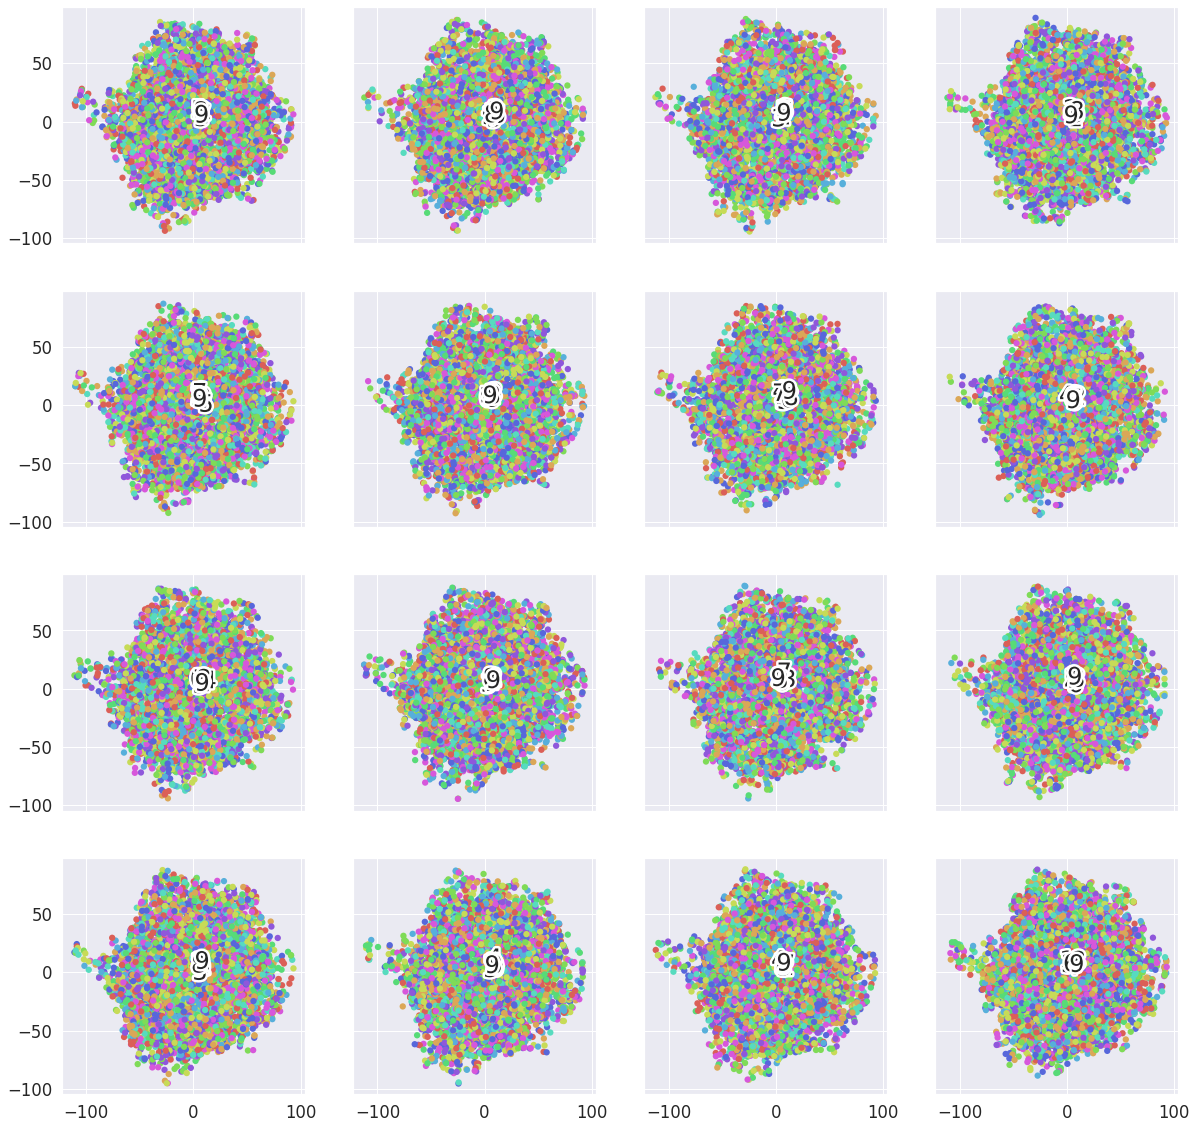

In [ ]:
print(predictions.shape)

from sklearn.manifold import TSNE
import matplotlib.patheffects as PathEffects
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import time

from sklearn.decomposition import PCA

sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})
RS = 123


def plot_tSNE_per_pixel(dataset, colors):
    """
    Plot the t-SNE projection of a given dataset. The dataset is a batch of 3-tensors
    and the function makes as many plots as pixels in the dataset (typically used when
    the latent space is a tensor space)
    :param dataset: t-SNE outputs
    :param colors: original labels which serve as colors

    :return: matplotlib figure, axis, scatter and texts
    """

    plots = []  # rows and columns but not depth
    for x in range(dataset.shape[1]):  # rows
        for y in range(dataset.shape[2]): # columns
            pixs = dataset[:, x, y]  # batch of super-pixel
            tsne = TSNE().fit_transform(pixs)
            plots.append(tsne)
            print(f"Done super-pixel ({x}, {y})")

    plots = np.array(plots).reshape((*dataset.shape[:3], 2))

    fig, axes = plt.subplots(dataset.shape[1], dataset.shape[2], figsize=(20, 20),
                             sharex="all", sharey="all")

    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors)) + 1
    palette = np.array(sns.color_palette("hls", num_classes))
    #     palette = np.array(colors)

    txts, scs = [], []
    # create a scatter plot.
    for i in range(plots.shape[1]):
        for j in range(plots.shape[2]):
            ax, x_sne, y_sne = axes[i][j], plots[:, i, j, 0], plots[:, i, j, 1]
            print(x_sne.shape, y_sne.shape)
            scs.append(ax.scatter(x_sne, y_sne, lw=0, s=40, c=palette[colors.astype(np.int)]))
            plt.xlim(-25, 25)
            plt.ylim(-25, 25)
            ax.axis('on')
            ax.axis('tight')

            # add the labels for each digit corresponding to the label
            for k in range(num_classes):
                # Position of each label at median of data points.

                xtext, ytext = np.median(x_sne[colors == k], axis=0), np.median(y_sne[colors == k], axis=0)
                txt = ax.text(xtext, ytext, str(k), fontsize=24)
                txt.set_path_effects([
                    PathEffects.Stroke(linewidth=5, foreground="w"),
                    PathEffects.Normal()])
                txts.append(txt)

    return fig, axes, scs, txts

plot_tSNE_per_pixel(predictions, y_test[:5000])

Seems like there is no super-pixel that allows to separate properly each class. The information from each must be taken into account.